<a href="https://colab.research.google.com/github/mayraberrones94/Aprendizaje/blob/main/HW_3_Univariant_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions:

Repeat the steps of the prostate cancer example in Section 3.2.1 using Python, first as a uni-variate problem using the book's data set and then as a multi-variate problem with data from your own project. 

Calculate also the p-values and the confidence intervals for the model's coefficients for the uni-variate version. Experiment, using libraries, also with subset selection.

For this problem we are using the prostate cancer dataset, which can be found [here](). The data came from a study that examines the correlation between the level of prostate specific antigen (PSA) and number of mesures. The goal is to predict the log of PSA (lpsa).

Here is a brief description of the data:

Column name | Second column name 
-------------------|------------------
lpsa       | Log of prostate specific antigen
lcavol     | Log cancer volume
lweight     | Log prostate weight
age     | Age of patient
lbph     | Log of benign prostatic hyperplasia
svi     | Seminal vesicle invarion
lcp     | Log of capsular penetration
gleason     | Gleason score
pgg45  |Percent of Gleason scores 4 or 5



First we load our [dataset]():

In [51]:
import numpy as np
import pandas as pd

from scipy import stats

dataset = pd.read_csv('/content/drive/MyDrive/Datasets/prostateData.csv')
print(dataset.shape)

dataset.drop('id', axis=1, inplace=True)

(97, 11)


In [52]:
dataset.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


Reading further into the example of prostate cancer we realize, since the goal is to examine the correlation of `lpsa`, so this becomes our target variable. All the other columns are the features that we need to analyse in order to see which ones will help us in our models. The `train` coulmn marks the division between our training and data set. 

Next up we divide and name our training and test sets.

In [53]:
target = 'lpsa'
# based on the following features
features = ['lcavol', 'lweight', 'age', 'lbph',
            'svi', 'lcp', 'gleason', 'pgg45']

train_st = dataset.train == 'T'
X, y = dataset[features].values, dataset[target].values
X_train, y_train = X[train_st], y[train_st]
X_test, y_test = X[~train_st], y[~train_st]

Table 3.1 in the book shows the correlation of predictors in the dataset. We wanted it to look similar to what we had in the book, so we print it as a traingle correlation matrix.

In [54]:
df_corr = dataset[train_st].corr()

#https://www.marsja.se/correlation-matrix-python-numpy-pandas/
def triang(cormat, triang='lower'):
    
    if triang == 'upper':
        rstri = pd.DataFrame(np.triu(cormat.values),
                             index=cormat.index,
                             columns=cormat.columns).round(3)
        rstri = rstri.iloc[:,1:]
        rstri.drop(rstri.tail(1).index, inplace=True)
        
    if triang == 'lower':
        rstri = pd.DataFrame(np.tril(cormat.values),
                             index=cormat.index,
                             columns=cormat.columns).round(3)
        rstri = rstri.iloc[:,:-1]
        rstri.drop(rstri.head(1).index, inplace=True) 
 
    rstri.replace(to_replace=[0,1], value='', inplace=True)
    
    return(rstri)

triang(df_corr, 'lower')

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lweight,0.300,,,,,,,
age,0.286,0.317,,,,,,
lbph,0.063,0.437,0.287,,,,,
svi,0.593,0.181,0.129,-0.139,,,,
lcp,0.692,0.157,0.173,-0.089,0.671,,,
gleason,0.426,0.024,0.366,0.033,0.307,0.476,,
pgg45,0.483,0.074,0.276,-0.03,0.481,0.663,0.757,
lpsa,0.733,0.485,0.228,0.263,0.557,0.489,0.342,0.448


Seeing this table we can already tell which variables are strongly correlated. In the book they mention a scatterplot matrix that show that the `svi` variable is binary, and `gleason` is an ordered categorical value. So we plot this matrix with the help of seaborn.

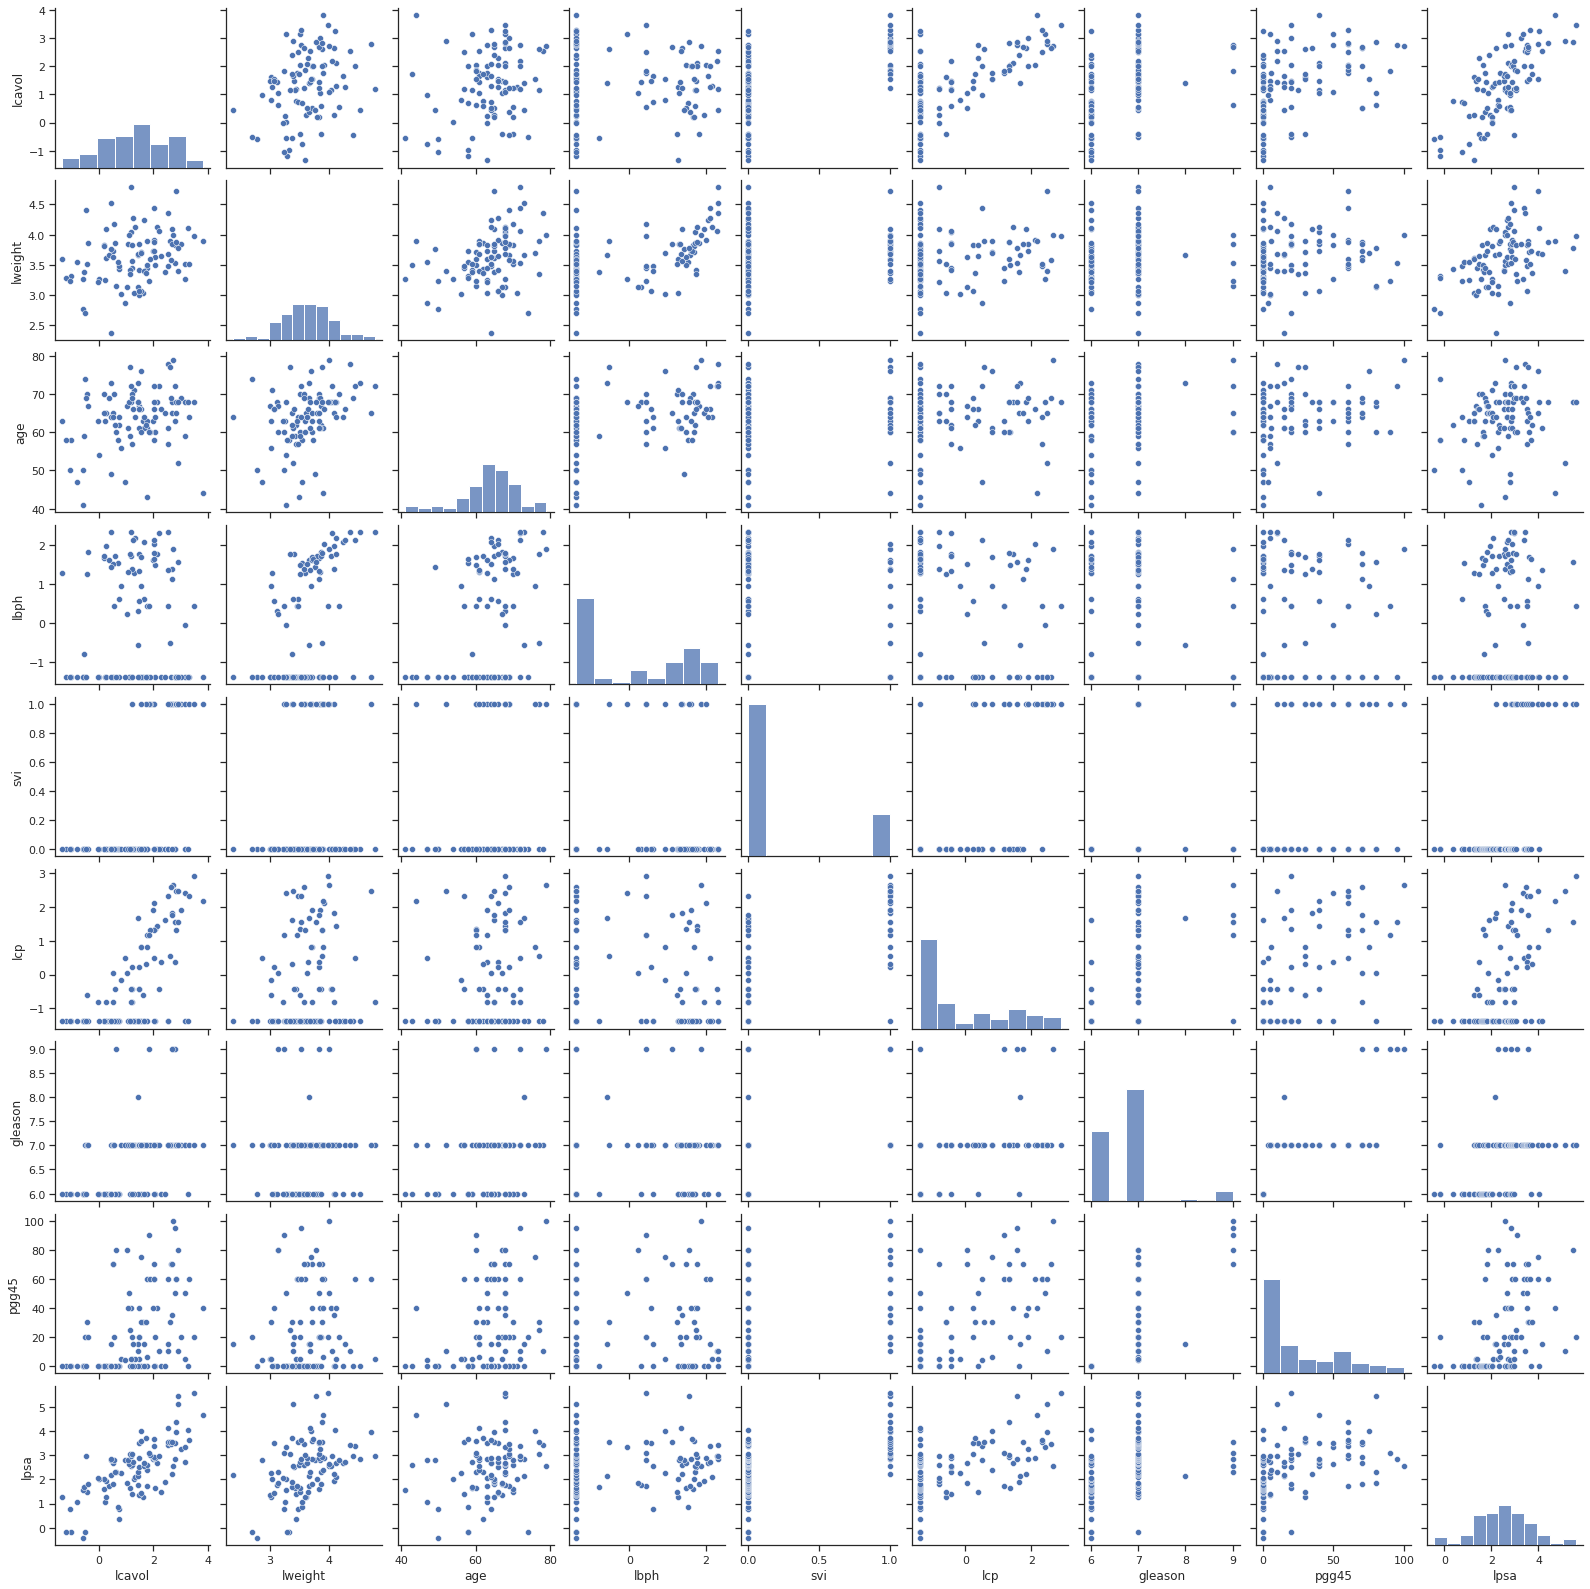

In [55]:
import seaborn as sns

sns.set_theme(style = "ticks")
sns.pairplot(dataset)

Then for table 3.2, they fit a linear model to the lpsa after first standarizing the predictors to have unit variance.

In [56]:
#https://scikit-learn.org/stable/modules/preprocessing.html

from sklearn import preprocessing
import numpy as np

scaler = preprocessing.StandardScaler().fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
#https://www.statsmodels.org/0.6.1/examples/notebooks/generated/ols.html
import statsmodels.api as sm

model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
ls_params = model.params

result = zip(['Intercept'] + features, ls_params, model.bse, model.tvalues)
print('      Term   Coefficient   Std. Error   Z Score')
print('-----------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>10}{coefficient:>14.2f}{std_err:>13.2f}{z_score:>10.2f}')

      Term   Coefficient   Std. Error   Z Score
-----------------------------------------------
 Intercept          2.46         0.09     27.60
    lcavol          0.68         0.13      5.37
   lweight          0.26         0.10      2.75
       age         -0.14         0.10     -1.40
      lbph          0.21         0.10      2.06
       svi          0.30         0.12      2.47
       lcp         -0.29         0.15     -1.87
   gleason         -0.02         0.14     -0.15
     pgg45          0.27         0.15      1.74


In the book they mention that the Z-scores mesure the effect that the model will have if we drop a variable. A Z-score greater than 2 in absolute value is approx. significant at 5% level. Based on the Z-score we can consider `age`, `lcp`, `gleason`, and pgg45 as variables we can get rid off.

They mention the F-statistic to test for the exclusion of several features at the same time. The F-statistic mesures the change in residual sum of squares per aditional parameter in the bigger model. 

We have as F-statistic:

$F = \frac{(RSS_0 - RSS_1) / (p_1 - p_0)}{RSS_1/(N-p_1-1)}$

In [58]:
y_hat = model.predict(sm.add_constant(X_test))
ls_error_rate = mean_squared_error(y_test, y_hat)
ls_std_error = np.std((y_test - y_hat)**2, ddof=1)/np.sqrt(y_test.size)
print(f'Least Squares Test Error: {ls_error_rate:.3f}')
print(f'               Std Error: {ls_std_error:.3f}')


Least Squares Test Error: 0.521
               Std Error: 0.179


In [59]:
from scipy import stats

rss1 = sum((model.predict(sm.add_constant(X_train)) - y_train) ** 2)
print("RSS1 = ", rss1)

RSS1 =  29.4263844599084


In [60]:
# based on the following features
features1 = ['lcavol', 'lweight', 'lbph',
            'svi']

train_st = dataset.train == 'T'
X1, y1 = dataset[features1].values, dataset[target].values
X_train1, y_train1 = X1[train_st], y1[train_st]
X_test1, y_test1 = X1[~train_st], y1[~train_st]

scaler = preprocessing.StandardScaler().fit(X1)
X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)

import statsmodels.api as sm

model1 = sm.OLS(y_train1, sm.add_constant(X_train1)).fit()
ls_params = model.params

result = zip(['Intercept'] + features1, ls_params, model.bse, model.tvalues)
print('      Term   Coefficient   Std. Error   Z Score')
print('-----------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>10}{coefficient:>14.2f}{std_err:>13.2f}{z_score:>10.2f}')

      Term   Coefficient   Std. Error   Z Score
-----------------------------------------------
 Intercept          2.46         0.09     27.60
    lcavol          0.68         0.13      5.37
   lweight          0.26         0.10      2.75
      lbph         -0.14         0.10     -1.40
       svi          0.21         0.10      2.06


In [61]:
rss0 = sum((model1.predict(sm.add_constant(X_train1)) - y_train1) ** 2)
print("RSS0 = ", rss0)

RSS0 =  32.81499474881555


In [62]:
p1 = len(features) + 1
p0 = len(features1) + 1
N = len(y_train)

In [63]:
f_statistic = ((rss0 - rss1)/ (p1 - p0))/(rss1 / (N - p1 - 1))
print("F = ", f_statistic)

F =  1.6409660073161834


In [70]:
prob = 1 - stats.f.cdf(f_statistic, (p1 - p0), (N - p1) )
print("RSS01 = ", rss1)
print("RSS0 = ", rss0)
print("F = ", f_statistic)
print('p-value = ', prob)

RSS01 =  29.4263844599084
RSS0 =  32.81499474881555
F =  1.6409660073161834
p-value =  0.1762476548551386


In [74]:
#https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_baseline.html

#https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html

import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

test_error = np.mean((y_test - model.predict(sm.add_constant(X_test))) ** 2)
base_error_rate = mean_squared_error(y_test, dummy_regr.predict(X_test))
print('Test Error: ', test_error)
print('Baseline Test Error: ', base_error_rate)


Test Error:  0.5212740055075993
Baseline Test Error:  1.056733228060382


In [103]:
coef_intervals = model.conf_int(0.05)
coef_intervals

array([[ 2.28614957,  2.64371628],
       [ 0.42385077,  0.92818192],
       [ 0.07126221,  0.45212501],
       [-0.34254432,  0.06107683],
       [ 0.00550433,  0.41261671],
       [ 0.05748914,  0.54975751],
       [-0.59472734,  0.02072365],
       [-0.31043629,  0.26804642],
       [-0.04032572,  0.57147799]])

In [108]:
low = []
high = []
for (x, y) in coef_intervals:
  low.append(x)
  high.append(y)

data = {'Term':  ['Intercept','lcavol', 'lweight', 'age', 'lbph',
            'svi', 'lcp', 'gleason', 'pgg45'],
        'Low coef': low,
        'High coef': high}

df = pd.DataFrame(data)
df

,Term,Low coef,High coef
0,Intercept,2.286150,2.643716
1,lcavol,0.423851,0.928182
2,lweight,0.071262,0.452125
3,age,-0.342544,0.061077
4,lbph,0.005504,0.412617
5,svi,0.057489,0.549758
6,lcp,-0.594727,0.020724
7,gleason,-0.310436,0.268046
8,pgg45,-0.040326,0.571478
